## <b> Traffic Sign Classification </b>

In this project, a Convolutional Neural Network will be employed in the classification of traffic signs. The model will be built using the tensorflow and keras modules. This model can be used to make smarter cars.

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

Visualising some images of traffic signs from the dataset. We can see that the images are unevenly sized.

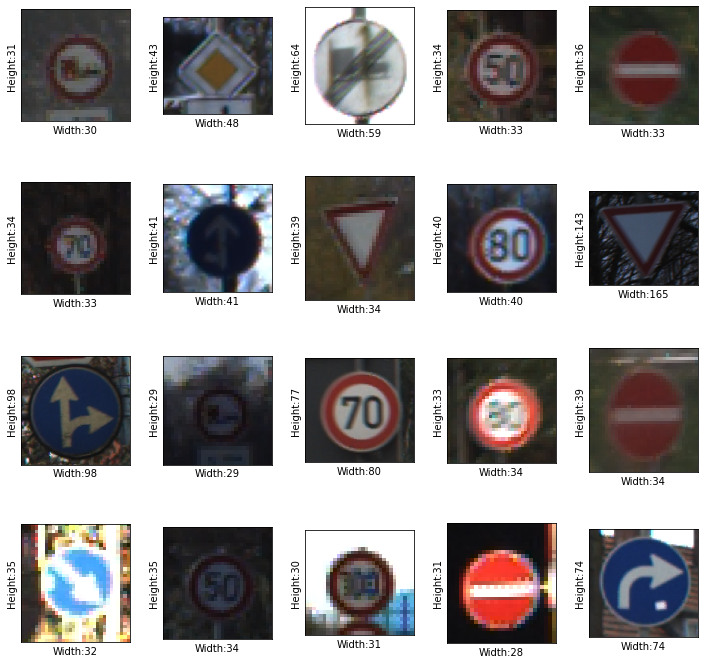

In [17]:
plt.figure(figsize = (10,10))
path = 'Test'
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.tight_layout()
    rand_img = imread(path + '/' + random.choice(sorted(os.listdir(path))))
    plt.xlabel("Width:" + str(rand_img.shape[1]))
    plt.ylabel("Height:" + str(rand_img.shape[0]))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(rand_img)

In order to size them equally, the input shape will be (50,50)

In [97]:
IMAGE_SIZE=50

### Getting the data ready

Loading in the Train document

In [41]:
labels_csv = pd.read_csv('Train.csv')
print(len(labels_csv))
labels_csv.head()

39209


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


Check for imbalance

210 2250
43


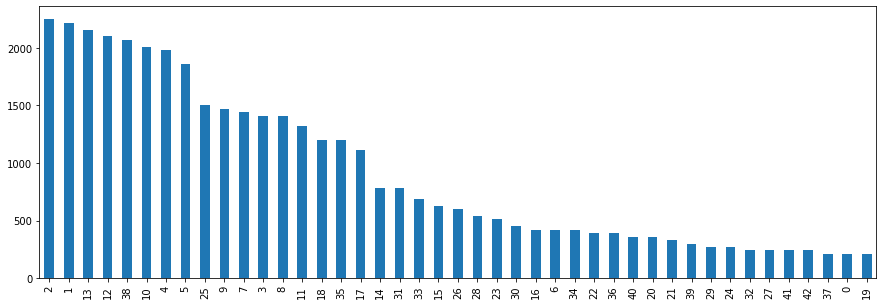

In [117]:
labels_csv['ClassId'].value_counts().plot.bar(figsize = (15, 5))
unique_labels = np.unique(labels_csv['ClassId'])
print(labels_csv['ClassId'].value_counts().min(), labels_csv['ClassId'].value_counts().max())
print(len(unique_labels))

Correct Imbalance

In [66]:
# Get a list of DataFrames. One for each class
min_count = labels_csv['ClassId'].value_counts().min()

class_df_list = []
for i in range(labels_csv['ClassId'].max() + 1):
    class_df = labels_csv[labels_csv['ClassId'] == i]
    remove_n = len(class_df) - min_count
    drop_indices = np.random.choice(class_df.index, remove_n, replace=False)
    class_df = class_df.drop(drop_indices)
    class_df_list.append(class_df)

balanced_labels = pd.concat(class_df_list)
balanced_labels.index = np.array(range(len(balanced_labels))) + 1

<AxesSubplot:>

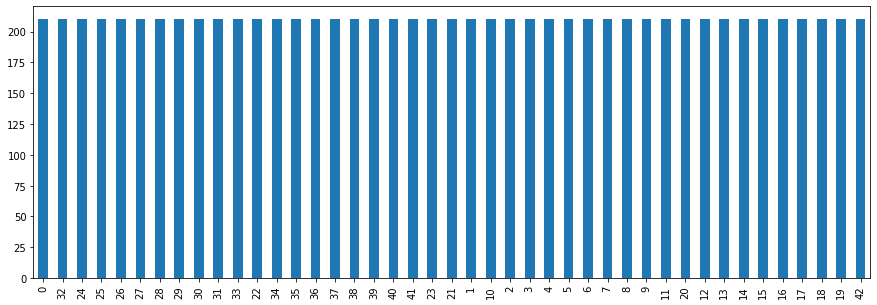

In [59]:
balanced_labels['ClassId'].value_counts().plot.bar(figsize = (15, 5))

# Everything is balanced now

In [130]:
filenames = list(balanced_labels['Path'])
labels = list(balanced_labels['ClassId'])
len(labels) == len(filenames)

True

Binarizing the Labels

In [131]:
binary_labels = to_categorical(labels)
len(binary_labels)

9030

### Creating a validation set

In [134]:
X = filenames
y = binary_labels

In [135]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val)

(7224, 1806, 7224, 1806)

### Preprocessing Images

In [133]:
def process_image(image_path):
    # Take an image and turn it to a tf Tensor
    image = tf.io.read_file(image_path) # Reads the image from the file path
    image = tf.image.decode_jpeg(image, channels=3) # Turns the image to a Tensor
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    return image

### Batchify the Data (It's a lot to train at once)

In [149]:
# First of all, we put each data entry in tuple form
def get_image_label(image_path, label):
    image = process_image(image_path)
    return image, label

In [156]:
BATCH_SIZE = 32

# Write the batchify function
def create_data_batches(X, y=None, batch_size =BATCH_SIZE, val_data=False, test_data = False):
    if test_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch
    
    elif val_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

    else:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data = data.shuffle(buffer_size = len(X))
        data = data.map(get_image_label)
        data_batch = data.batch(batch_size)
        return data_batch

In [157]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, val_data = True)

Run a few dimensionality checks

In [158]:
len(next(train_data.as_numpy_iterator()))

2

In [159]:
len(next(train_data.as_numpy_iterator())[0]), len(next(train_data.as_numpy_iterator())[1])

(20, 20)

In [160]:
next(train_data.as_numpy_iterator())[0].shape, next(train_data.as_numpy_iterator())[1].shape

((20, 50, 50, 3), (20, 43))

In [167]:
next(train_data.as_numpy_iterator())[1][0], next(train_data.as_numpy_iterator())[0][0]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 array([[[0.30588236, 0.34117648, 0.23137257],
         [0.33882356, 0.35490197, 0.25058824],
         [0.36078432, 0.35490197, 0.2529412 ],
         ...,
         [0.20000002, 0.18823531, 0.11568628],
         [0.20039219, 0.19960788, 0.1364706 ],
         [0.19215688, 0.18039216, 0.1254902 ]],
 
        [[0.2939608 , 0.31733334, 0.22541179],
         [0.30395296, 0.31645492, 0.23002355],
         [0.31309804, 0.31317648, 0.23058826],
         ...,
         [0.28792158, 0.27466667, 0.16635296],
         [0.2573177 , 0.253553  , 0.17372552],
         [0.2219608 , 0.2072157 , 0.15231374]],
 
        [[0.26901963, 0.2792157 , 0.19529413],
         [0.28988236, 0.2984314 , 0.21505885],
         [0.2992157 , 0.30588236, 0.22705884],
         ...,
         [0.287451  , 0.27137256, 

In [162]:
train_data.element_spec, val_data.element_spec # Done to know the shape of our input

((TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)))

### Building the Model

In [163]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size=(3,3), input_shape = [IMAGE_SIZE, IMAGE_SIZE, 3], activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size =(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size =(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size =(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(len(unique_labels), activation = 'softmax'))

In [172]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [165]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 50, 50, 64)        1792      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 25, 25, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 11, 11, 64)       

In [173]:
r = model.fit(x = train_data, epochs = 50, validation_data = val_data, verbose = 2)

Epoch 1/50
362/362 - 458s - loss: 3.6169 - accuracy: 0.0471 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - 458s/epoch - 1s/step
Epoch 2/50
362/362 - 127s - loss: 2.7109 - accuracy: 0.2216 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - 127s/epoch - 350ms/step
Epoch 3/50
362/362 - 130s - loss: 1.9940 - accuracy: 0.3829 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - 130s/epoch - 360ms/step
Epoch 4/50
362/362 - 140s - loss: 1.6122 - accuracy: 0.4949 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - 140s/epoch - 387ms/step
Epoch 5/50
362/362 - 700s - loss: 1.2713 - accuracy: 0.5832 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - 700s/epoch - 2s/step
Epoch 6/50
362/362 - 218s - loss: 1.0585 - accuracy: 0.6491 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - 218s/epoch - 602ms/step
Epoch 7/50
362/362 - 123s - loss: 0.9231 - accuracy: 0.6899 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - 123s/epoch - 339ms/step
Epoch 8/50
362/362 - 132s - loss: 0.7867 - accuracy: 0

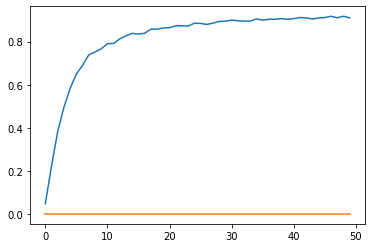

In [174]:
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])

### Testing the Model

In [169]:
test_csv = pd.read_csv('Test.csv')
test_csv

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
...,...,...,...,...,...,...,...,...
12625,42,41,5,6,37,36,12,Test/12625.png
12626,50,51,6,5,45,46,33,Test/12626.png
12627,29,29,6,6,24,24,6,Test/12627.png
12628,48,49,5,6,43,44,7,Test/12628.png


In [171]:
Xtest = test_csv['Path']
test_data = create_data_batches(Xtest, test_data = True)

In [175]:
predictions = model.predict(test_data)

In [176]:
pred_list = np.zeros(len(Xtest))
for i in range(len(Xtest)):
    pred_list[i] = np.argmax(predictions[i])

bool_test = pred_list == test_csv['ClassId']
test_accuracy = bool_test.sum()/len(bool_test)
test_accuracy

0.9409342834520982

### Conclusion

We downloaded the dataset, preprocessed it, created the model and made predictions using the model. During preprocessing, we found out that the number of classes is 43. The model reached a train accuracy of 91% in 50 epochs. It achieved a test accuracy of 94%.

The model can be further optimised using hyper parameter tuning.